In [14]:
import repo.utils.mnist_reader as mnist_reader

X_train, y_train = mnist_reader.load_mnist('repo/data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('repo/data/fashion', kind='t10k')

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(60000, 784) (60000,)
(10000, 784) (10000,)


In [15]:
print(type(X_train))
print(type(y_train))
print(type(X_test))
print(type(y_test))


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


# Narrowing to two classes for training data

In [16]:
import numpy as np

num_data_points = len(X_train)

X_train_new = []
y_train_new = []

for i in range(num_data_points):
    if y_train[i] == 5:
        X_train_new.append(X_train[i])
        y_train_new.append(0)
    elif y_train[i] == 7:
        X_train_new.append(X_train[i])
        y_train_new.append(1)



X_train_new = np.array(X_train_new)
y_train_new = np.array(y_train_new)

X_train = X_train_new
y_train = y_train_new

X_train_og = X_train
y_train_og = y_train

print(X_train.shape)
print(y_train.shape)

(12000, 784)
(12000,)


## Narrowing it to 3000 values for each case

In [17]:
num_samples_per_case = 1500

np.random.seed(42)

class_0_indices = np.where(y_train== 0)[0]
class_1_indices = np.where(y_train == 1)[0]

class_0_indices = np.random.choice(class_0_indices, num_samples_per_case, replace=False)
class_1_indices = np.random.choice(class_1_indices, num_samples_per_case, replace=False)

X_train_short = np.concatenate([X_train[class_0_indices], X_train[class_1_indices]])
y_train_short = np.concatenate([np.zeros(num_samples_per_case), np.ones(num_samples_per_case)])

indices = np.random.permutation(len(X_train_short))
X_train_short = X_train_short[indices]
y_train_short = y_train_short[indices]

X_train = X_train_short
y_train = y_train_short

print(X_train_short.shape)
print(y_train_short.shape)

# for i in range(6000):
    # print("Printing")
    # print(y_train_short[i])

# for i in range (6000):
#     if i == 3000:
#         print('halfway')
#     print(y_train[i])


(3000, 784)
(3000,)


## Narrowing to two classes for testing data

In [18]:
import numpy as np

num_data_points = len(X_test)

X_test_new = []
y_test_new = []

for i in range(num_data_points):
    if y_test[i] == 5:
        X_test_new.append(X_test[i])
        y_test_new.append(0)
    elif y_test[i] == 7:
        X_test_new.append(X_test[i])
        y_test_new.append(1)

X_test_new = np.array(X_test_new)
y_test_new = np.array(y_test_new)

X_test = X_test_new
y_test = y_test_new

X_test_og = X_test
y_test_og = y_test

## Normalizing Data

In [19]:
from sklearn.preprocessing import StandardScaler

# Assume X_train and X_test are your training and test feature matrices
scaler = StandardScaler()

# Fit on training data and transform training data
X_train = scaler.fit_transform(X_train)

# Transform test data using the same scaler (without refitting)
X_test = scaler.transform(X_test)


# Adding noise

In [20]:
"""Select a probability in the range from 0.1 to 0.3 (e.g., you might pick 0.1, or 0.2, or 0.25,
 etc.). Fix this value, and call it p.
 Now, independently for each example in the training set, flip its label with probability p.
 This is called adding “label noise”. It makes the labels noisy and makes machine learning
 algorithms more likely to overfit"""

p = 0.2 # Probabilty

def flip_labels(y):
    y_noisy = y.copy()
    for i in range(len(y)):
        random_number = np.random.rand() #Random num between 0 and 1
        if random_number < p:
            y_noisy[i] = 1 - y_noisy[i]
    return y_noisy


y_train_noisy = flip_labels(y_train)


#Sanity check
same = 0
diff = 0
for i in range(len(y_train)):
    if y_train[i] == y_train_noisy[i]:
        same += 1
    else:
        diff += 1

print(same, diff)
print(diff / len(y_train))

2387 613
0.20433333333333334


## NOW WE ARE ACTUALLY BUILD A MODEL WITH TUNING

Data to work with

x training data: X_train
y training data: y_train_noisy

x testing data: x_test
y testing data: y_test


# Baseline model for reference, to delete

In [8]:
# from sklearn.model_selection import train_test_split
# from sklearn.svm import SVC
# from sklearn.metrics import accuracy_score

# kernal = 'linear'

# svm = SVC(kernel=kernal, C=1.0)

# svm.fit(X_train, y_train_noisy)

# y_pred = svm.predict(X_test)

# accuracy = accuracy_score(y_test, y_pred)
# print(f'Accuracy: {accuracy * 100:.2f}%')



# Finding values for c, before performing cross-fold validation

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

X_train, X_val, y_train_noisy, y_val_noisy = train_test_split(X_train, y_train_noisy, test_size=0.2, random_state=42)

potential_c_values = [0.00025, 0.0005, 0.001, 0.002, 0.004, 0.008, 0.016, 0.032, 0.064, 0.128, 0.256, 0.512, 1.024, 2.048, 4.096, 8.192]

kernal = 'linear'

errors = []

for c_val in potential_c_values:

    print("working on c_val: ", c_val)

    svm = SVC(kernel=kernal, C=c_val)

    svm.fit(X_train, y_train_noisy)

    y_pred = svm.predict(X_val)

    accuracy = accuracy_score(y_val_noisy, y_pred)

    errors.append(1 - accuracy)

    print(1-accuracy)

for i in range(len(potential_c_values)):
    print(f'{potential_c_values[i]}: {errors[i]}')


working on c_val:  0.00025
0.2733333333333333
working on c_val:  0.0005
0.2666666666666667
working on c_val:  0.001
0.26
working on c_val:  0.002
0.2683333333333333
working on c_val:  0.004
0.2666666666666667
working on c_val:  0.008
0.29000000000000004
working on c_val:  0.016
0.30166666666666664
working on c_val:  0.032
0.31499999999999995
working on c_val:  0.064
0.32333333333333336
working on c_val:  0.128
0.32833333333333337
working on c_val:  0.256
0.33999999999999997
working on c_val:  0.512
0.355
working on c_val:  1.024
0.36
working on c_val:  2.048
0.3566666666666667
working on c_val:  4.096
0.3466666666666667
working on c_val:  8.192
0.3516666666666667
0.00025: 0.2733333333333333
0.0005: 0.2666666666666667
0.001: 0.26
0.002: 0.2683333333333333
0.004: 0.2666666666666667
0.008: 0.29000000000000004
0.016: 0.30166666666666664
0.032: 0.31499999999999995
0.064: 0.32333333333333336
0.128: 0.32833333333333337
0.256: 0.33999999999999997
0.512: 0.355
1.024: 0.36
2.048: 0.3566666666666

# Plotting the validation from above

In [10]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter


def plot_errors(training_errors, title):
    plt.figure(figsize=(10, 6))
    plt.plot(potential_c_values, training_errors, label='Validation Error',  linestyle='-', color='orange', marker='o', markersize=5)

    plt.title(title)
    plt.xlabel('C Value')
    plt.ylabel('Error')
    plt.legend()

    plt.xscale('log')


    plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1))


    plt.grid(True)
    plt.show()

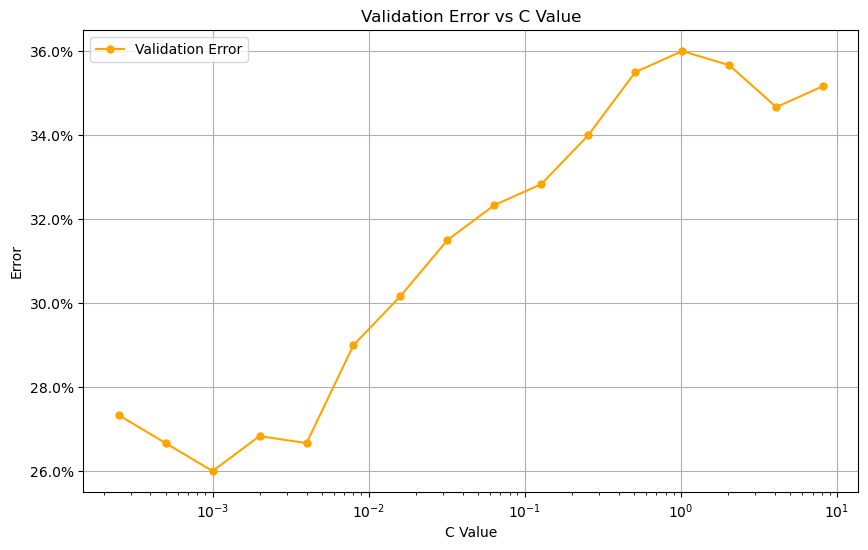

In [11]:
plot_errors(errors, 'Validation Error vs C Value')

# K fold cross validation

In [21]:
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

def k_fold_cross_validation(k, ensemble, training_features, labels):


    kernel = 'linear'
    num_samples = training_features.shape[0]

    training_features_folds = []
    labels_folds = []

    # Split the data into k folds
    for i in range(k):
        training_features_folds.append(training_features[i * num_samples // k : (i + 1) * num_samples // k])
        labels_folds.append(labels[i * num_samples // k : (i + 1) * num_samples // k])

    best_error = float('inf')
    best_ensemble_value = ensemble[0]

    for value in ensemble:

        print("Ensemble value:", value)

        sum_error = 0
        average_error = 0

        for i in range(k):
            training_features_fold = np.vstack([training_features_folds[j] for j in range(k) if j != i])
            training_target_fold = np.hstack([labels_folds[j] for j in range(k) if j != i])


            test_features = training_features_folds[i]
            test_target = labels_folds[i]

            svm = SVC(kernel=kernel, C=value)
            svm.fit(training_features_fold, training_target_fold)

            predictions = svm.predict(test_features)
            accuracy = accuracy_score(test_target, predictions)

            error = 1 - accuracy
            sum_error += error

        average_error = sum_error / k

        print("Average Error:", average_error)

        if average_error < best_error:
            print("New best error:", average_error)
            print("New best ensemble value:", value)
            best_error = average_error
            best_ensemble_value = value

    print("Best value:", best_ensemble_value)
    print("Best error:", best_error)

    return best_ensemble_value

        

## Finding optimal C value

In [22]:
print(X_train.shape[0])
print(y_train_noisy.shape)


3000
(3000,)


In [24]:
c_values = [0.00025, 0.0005, 0.001, 0.002, 0.004, 0.008, 0.016, 0.032, 0.064, 0.128, 0.256, 0.512, 1.024, 2.048, 4.096, 8.192]

best_c_value = k_fold_cross_validation(5, c_values, X_train, y_train_noisy)

print("Best c value:", best_c_value)

Ensemble value: 0.00025
Average Error: 0.2553333333333333
New best error: 0.2553333333333333
New best ensemble value: 0.00025
Ensemble value: 0.0005
Average Error: 0.254
New best error: 0.254
New best ensemble value: 0.0005
Ensemble value: 0.001
Average Error: 0.255
Ensemble value: 0.002
Average Error: 0.25799999999999995
Ensemble value: 0.004
Average Error: 0.26399999999999996
Ensemble value: 0.008
Average Error: 0.274
Ensemble value: 0.016
Average Error: 0.2833333333333333
Ensemble value: 0.032
Average Error: 0.2926666666666667
Ensemble value: 0.064
Average Error: 0.3
Ensemble value: 0.128
Average Error: 0.30966666666666665
Ensemble value: 0.256
Average Error: 0.31766666666666665
Ensemble value: 0.512
Average Error: 0.3263333333333333
Ensemble value: 1.024
Average Error: 0.33566666666666667
Ensemble value: 2.048
Average Error: 0.33833333333333326
Ensemble value: 4.096
Average Error: 0.341
Ensemble value: 8.192
Average Error: 0.3496666666666667
Best value: 0.0005
Best error: 0.254
Bes

# Plotting the k-fold cross-validation results

In [30]:
c_values_to_plot = [0.00025, 0.0005, 0.001, 0.002, 0.004, 0.008, 0.016, 0.032, 0.064, 0.128, 0.256, 0.512, 1.024, 2.048, 4.096, 8.192]
average_errors_to_plot = [0.2553333333333333, 0.254, 0.255, 0.25799999999999995, 0.26399999999999996, 0.274, 0.2833333333333333, 0.2926666666666667, 0.3, 0.30966666666666665, 0.31766666666666665, 0.3263333333333333, 0.33566666666666667, 0.33833333333333326, 0.341, 0.3496666666666667]




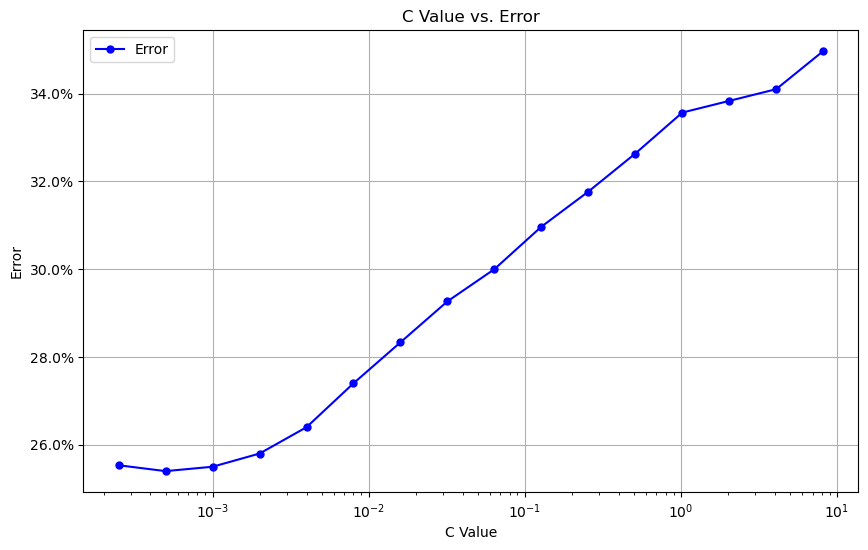

In [31]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

def plot_c_vs_error(c_values, errors, title="C Value vs. Error"):
    plt.figure(figsize=(10, 6))
    plt.plot(c_values, errors, linestyle='-', color='blue', marker='o', markersize=5, label='Error')

    plt.title(title)
    plt.xlabel('C Value')
    plt.ylabel('Error')
    plt.legend()

    plt.xscale('log')  # Log scale since C values often span several orders of magnitude
    plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1))  # Format y-axis as percentages

    plt.grid(True)
    plt.show()

plot_c_vs_error(c_values_to_plot, average_errors_to_plot, 'C Value vs. Error')

# Stop here

## Making final model

In [25]:
print(X_train_og.shape[0])
print(y_train_og.shape[0])

print(X_test_og.shape[0])
print(y_test_og.shape[0])


12000
12000
2000
2000


In [32]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3000, 784)
(2000, 784)
(3000,)
(2000,)


In [33]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


c_values = [0.00025, 0.0005, 0.001, 0.002, 0.004, 0.008, 0.016, 0.032, 0.064, 0.128, 0.256, 0.512, 1.024, 2.048, 4.096, 8.192]

kernal = 'linear'

training_errors = []
testing_errors = []

for c_val in c_values:

    print("working on c_val: ", c_val)

    # svm = SVC(kernel=kernal, C=c_val)

    svm = SVC(kernel=kernal, C=c_val)

    svm.fit(X_train, y_train_noisy)

    y_train_pred = svm.predict(X_train)
    y_test_pred = svm.predict(X_test)

    training_accuracy = accuracy_score(y_train, y_train_pred)
    testing_accuracy = accuracy_score(y_test, y_test_pred)

    training_errors.append(1 - training_accuracy)
    testing_errors.append(1 - testing_accuracy)

    print("Training error:", 1 - training_accuracy)
    print("Testing error:", 1 - testing_accuracy)

    

working on c_val:  0.00025
Training error: 0.07366666666666666
Testing error: 0.0665
working on c_val:  0.0005
Training error: 0.06299999999999994
Testing error: 0.0615
working on c_val:  0.001
Training error: 0.05666666666666664
Testing error: 0.0635
working on c_val:  0.002
Training error: 0.058666666666666645
Testing error: 0.0665
working on c_val:  0.004
Training error: 0.061000000000000054
Testing error: 0.07050000000000001
working on c_val:  0.008
Training error: 0.06899999999999995
Testing error: 0.07850000000000001
working on c_val:  0.016
Training error: 0.07799999999999996
Testing error: 0.09299999999999997
working on c_val:  0.032
Training error: 0.08099999999999996
Testing error: 0.10650000000000004
working on c_val:  0.064
Training error: 0.09266666666666667
Testing error: 0.118
working on c_val:  0.128
Training error: 0.09999999999999998
Testing error: 0.132
working on c_val:  0.256
Training error: 0.10599999999999998
Testing error: 0.14600000000000002
working on c_val:  

# Plot

In [34]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter


def plot_errors(training_errors, testing_errors, title):
    plt.figure(figsize=(10, 6))
    plt.plot(c_values, training_errors, label='Training Error',  linestyle='-', color='orange', marker='o', markersize=5)
    plt.plot(c_values, testing_errors, label='Test Error', linestyle='-', color='blue', marker='o', markersize=5)

    plt.title(title)
    plt.xlabel('C Value')
    plt.ylabel('Error')
    plt.legend()

    plt.xscale('log')


    plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1))


    plt.grid(True)
    plt.show()

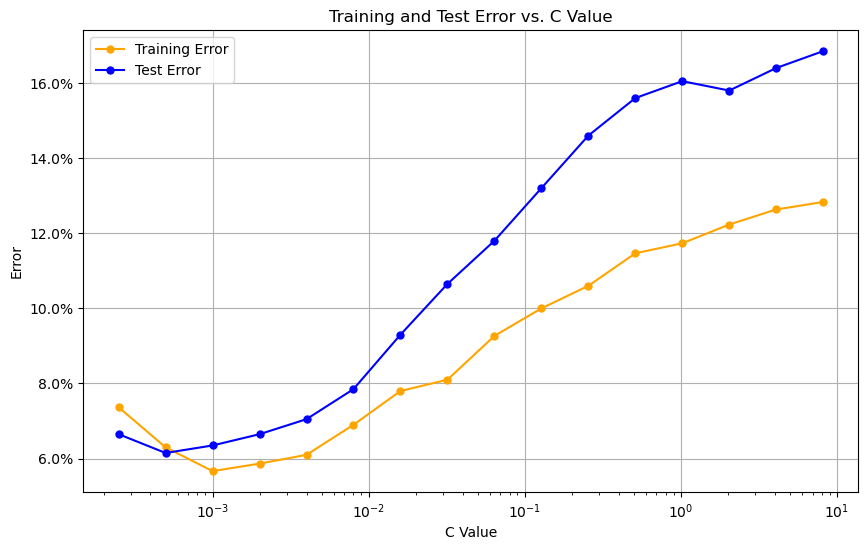

In [35]:
plot_errors(training_errors, testing_errors, 'Training and Test Error vs. C Value')